# Attribution par facteur
D’où vient le rendement d'un fonds ?  
On explique les rendements excédentaires du fonds par les facteurs académiques :
* βi​ = sensibilité du fonds au facteur i
* α = performance non expliquée par ces facteurs

Données utilisées :
* NAV mensuelles ou hebdomadaires du fonds/ETF
* Facteurs Fama-French

Description du fichier de facteurs :

`MonthId`
* Type : entier (YYYYMM)
* Description : Identifiant du mois de l’observation - Exemple : 196307 = juillet 1963.
* Usage : Sert d’index temporel pour aligner facteurs, rendements du fonds et séries macro.

`Mkt-RF`
* Nom complet : Excess Market Return
* Type : float (%)
* Définition : Rendement du portefeuille de marché (value-weighted US equities) moins le taux sans risque (RF).
* Interprétation : Facteur de risque de marché (le premier facteur CAPM).
* Usage en attribution : Charge en bêta du fonds → exposition directionnelle au marché.

`SMB`
* Nom complet : Small Minus Big
* Type : float (%)
* Définition : Surperformance moyenne des portefeuilles "petites capitalisations" sur les grandes capitalisations.
* Construction 2×3 : Moyenne de 6 portefeuilles classés par taille × 3 niveaux de “book-to-market”, “operating profitability”, “investment”.
* Interprétation : Prime de taille.
* Usage en attribution : Exposition aux small caps (portefeuilles spécialisés, value/small tilt, etc.).

`HML`
* Nom complet : High Minus Low (Value Factor)
* Type : float (%)
* Définition : Surperformance moyenne des actions Value (haut book-to-market) vs Growth (bas book-to-market).
* Construction 2×3 : Portefeuilles triés taille × book-to-market.
* Interprétation : Prime Value.
* Usage : Explique les biais Value/Growth.

`RMW`
* Nom complet : Robust Minus Weak (Profitability Factor)
* Type : float (%)
* Définition : Surperformance des entreprises à profitabilité robuste vs faible.
* Construction 2×3 : Portefeuilles triés taille × operating profitability.
* Interprétation : Prime de profitabilité (Cooper, Gulen, Schill ; Fama-French 2015).
* Usage : Détecte un tilt vers les entreprises “quality/profitable”.

`CMA`
* Nom complet : Conservative Minus Aggressive (Investment Factor)
* Type : float (%)
* Définition : Surperformance des entreprises faiblement investisseuses vs fortement investisseuses.
* Interprétation : Facteur d’investissement — entreprises prudentes vs expansion agressive.
* Usage : Explique les biais vers les entreprises conservatrices / capital-light.

`RF`
* Nom complet : Risk-Free Rate
* Type : float (%)
* Définition : Taux sans risque à un mois (T-bill 1-month).
* Usage : Permet de calculer les rendements excédentaires du fonds et sert au facteur Mkt-RF.

`UMD`
* Nom complet : Up Minus Down (Momentum Factor)
* Type : float (%)
* Définition : Surperformance moyenne des portefeuilles d’actions “gagnantes” (rendements passés élevés) sur les portefeuilles “perdantes” (rendements passés faibles), où les gagnants et perdants sont définis sur le rendement cumulé des 12 derniers mois hors le plus récent (mois t-12 à t-2), en pondération value-weighted.
* Interprétation : Prime de Momentum – les actions qui ont récemment bien performé tendent à continuer de surperformer, et inversement pour les perdantes.
* Usage : Mesure un tilt Momentum (β_UMD > 0) ou anti-Momentum (β_UMD < 0) d’un fonds ; permet de reclasser une partie de l’« alpha » comme exposition systématique à la stratégie gagnants–perdants.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson, jarque_bera

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Charger FF5
df_factors = pd.read_csv('FF5+Momentum.csv')

In [3]:
# Encodage date
df_factors['month_enddate'] = pd.to_datetime(df_factors['MonthId'], format='%Y%m') + pd.offsets.MonthEnd(0)
df_factors = df_factors.set_index('month_enddate').drop(columns=['MonthId'])

In [4]:
# Chargement des rendements de l'univers des ETF
df_returns_raw = pd.read_csv("iShares_ETF_monthly_returns.csv", parse_dates=["Date"])
df_returns_raw

,Date,IVV,IWB,IWF,IJH,IJR,IWM,IWD,IVW,IVE,...,MTUM,VLUE,SIZE,QUAL,DGRO,LRGF,SMLF,SMMV,SMMD,DIVB
0,2000-05-31,-2.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-06-30,2.47,2.51,7.60,1.48,5.89,8.69,-4.68,8.05,-3.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-07-31,-1.57,-1.70,-4.41,1.51,-2.48,-3.25,1.39,-4.48,1.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-08-31,6.19,7.44,9.18,11.13,8.82,7.59,5.54,5.77,6.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-09-30,-5.27,-4.68,-9.53,-0.69,-2.74,-3.24,0.86,-9.76,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2025-06-30,5.08,5.05,6.36,3.58,4.03,5.40,3.40,6.32,3.67,...,4.02,6.55,3.59,3.39,3.48,4.98,4.64,0.45,4.64,4.30
302,2025-07-31,2.24,2.21,3.76,1.62,0.92,1.71,0.56,3.41,0.87,...,0.33,-0.29,1.14,0.72,0.98,2.21,2.00,-1.26,1.91,-0.43
303,2025-08-31,2.03,2.10,1.10,3.39,7.05,7.13,3.18,0.81,3.43,...,1.02,5.95,2.31,2.57,3.53,1.96,5.37,4.03,5.30,3.98
304,2025-09-30,3.65,3.46,5.29,0.45,0.99,3.12,1.48,5.28,1.75,...,5.51,5.12,1.11,3.22,2.35,3.71,2.11,0.36,1.65,0.91


In [5]:
# unpivot / melt en format long
df_returns = (
    df_returns_raw
    .melt(id_vars="Date", var_name='ticker', value_name='monthly_return')
    .dropna(subset=['monthly_return'])  # retire les lignes sans données
    .sort_values(['Date', "ticker"])
    .reset_index(drop=True)
)

# affichage / sauvegarde
df_returns

,Date,ticker,monthly_return
0,2000-05-31,IVV,-2.12
1,2000-06-30,IJH,1.48
2,2000-06-30,IJR,5.89
3,2000-06-30,IVE,-3.93
4,2000-06-30,IVV,2.47
...,...,...,...
12101,2025-10-31,SMLF,-0.03
12102,2025-10-31,SMMD,0.64
12103,2025-10-31,SMMV,-2.58
12104,2025-10-31,USMV,-2.02


In [6]:
# Chargement des caractéristiques des ETF
df_universe = pd.read_csv("iShares_Universe.csv")
df_universe

,Ticker,Name,Inception Date,Category,Factor_bucket,Notes
0,IVV,iShares Core S&P 500 ETF,2000-05-15,Large Cap,Core,"S&P 500 low-cost, core US large caps."
1,IWB,iShares Russell 1000 ETF,2000-05-15,Large/Mid Cap,Core,Russell 1000 broad US large+mid core exposure.
2,IWF,iShares Russell 1000 Growth ETF,2000-05-22,Large/Mid Cap,Value-Growth,Russell 1000 growth sleeve (large+mid growth).
3,IJH,iShares Core S&P Mid-Cap ETF,2000-05-22,Mid Cap,Size,Core S&P Mid-Cap exposure (US mid caps).
4,IJR,iShares Core S&P Small-Cap ETF,2000-05-22,Small Cap,Size,Core S&P Small-Cap exposure (US small caps).
5,IWM,iShares Russell 2000 ETF,2000-05-22,Small Cap,Size,Russell 2000 benchmark for US small caps.
6,IWD,iShares Russell 1000 Value ETF,2000-05-22,Large/Mid Cap,Value-Growth,Russell 1000 value sleeve (large+mid value).
7,IVW,iShares S&P 500 Growth ETF,2000-05-22,Large Cap,Value-Growth,S&P 500 growth sleeve (large-cap growth).
8,IVE,iShares S&P 500 Value ETF,2000-05-22,Large Cap,Value-Growth,S&P 500 value sleeve (large-cap value).
9,IWV,iShares Russell 3000 ETF,2000-05-22,All Cap,Core,Russell 3000 broad US equity market (total mar...


In [7]:
series_by_ticker = {}

tickers = (
    df_universe["Ticker"]
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
)

tickers

array(['IVV', 'IWB', 'IWF', 'IJH', 'IJR', 'IWM', 'IWD', 'IVW', 'IVE',
       'IWV', 'IUSG', 'IUSV', 'IWO', 'IWN', 'IJK', 'IJJ', 'IJS', 'IJT',
       'OEF', 'IWR', 'IWP', 'IWS', 'DVY', 'ITOT', 'IMCG', 'ILCG', 'IMCB',
       'ILCB', 'ILCV', 'IMCV', 'ISCG', 'ISCV', 'ISCB', 'IWC', 'IWY',
       'IWX', 'IWL', 'EUSA', 'HDV', 'USMV', 'MTUM', 'VLUE', 'SIZE',
       'QUAL', 'DGRO', 'LRGF', 'SMLF', 'SMMV', 'SMMD', 'DIVB'],
      dtype=object)

In [8]:
# Boucle sur les tickers pour réaliser les régressions Factor Attribution
rows = []
for t in tickers:
    df_sub = (
        df_returns.loc[df_returns["ticker"].astype(str).str.strip() == t, ["Date", "monthly_return"]]
        .dropna()
        .copy()
    )

    if df_sub.empty:
        continue
    
    
    df_sub["Date"] = pd.to_datetime(df_sub["Date"])

    df_fund = df_sub.sort_values("Date").set_index("Date")
    df_fund.name = str(t).strip()
    series_by_ticker[df_fund.name] = df_fund

    # Ajout des facteurs
    df_fund = df_fund.join(df_factors, how='inner')
    if df_fund.empty:
        continue

    # Calcul du rendement excédentaire du fonds
    df_fund['fund_excess'] = df_fund['monthly_return'] - df_fund['RF']

    # Statsmodels OLS
    X = df_fund[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA','UMD']]
    X = sm.add_constant(X)
    y = df_fund['fund_excess']

    # garde-fou: pas de régression si trop peu d'observations
    if len(df_fund) < (X.shape[1] + 5):
        continue

    # cov_type='HAC' compute heteroskedasticity-and-autocorrelation-consistent covariances (Newey–West style). 
    # cov_kwds={'maxlags':6} supplies options to that estimator.
    # maxlags is the lag truncation used to account for serial correlation up to lag 6 (and typically uses a Bartlett kernel by default).
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':6})

    params = model.params.to_dict()
    row = {
        "ticker": str(t).strip(),
        "n_obs": int(model.nobs),
        "rsquared": float(model.rsquared),
        "rsquared_adj": float(model.rsquared_adj),
        "model_summary": model.summary().as_text(),
        **params,  # colonnes: const, Mkt-RF, SMB, ...
    }
    rows.append(row)

df_models = pd.DataFrame(rows)

base_cols = ["ticker", "n_obs", "rsquared", "rsquared_adj", "const", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "model_summary"]
df_models = df_models.reindex(columns=[c for c in base_cols if c in df_models.columns] + [c for c in df_models.columns if c not in base_cols])
df_models.to_csv("iShares_FF5_factor_attribution.csv", index=False)

In [9]:
series_by_ticker["IVV"]

,monthly_return
Date,
2000-05-31,-2.12
2000-06-30,2.47
2000-07-31,-1.57
2000-08-31,6.19
2000-09-30,-5.27
...,...
2025-06-30,5.08
2025-07-31,2.24
2025-08-31,2.03


In [10]:
# Paramètres
WINDOW = 60 # fenêtre de calcul des rolling beta (en mois)
FACTORS = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD"]
HAC_MAXLAGS = 6

rows = []
series_by_ticker = {}  # pour conserver les séries

for t in tickers:
    ticker = str(t).strip()

    df_sub = (
        df_returns.loc[df_returns["ticker"].astype(str).str.strip() == ticker, ["Date", "monthly_return"]]
        .dropna()
        .copy()
    )
    if df_sub.empty:
        continue

    df_sub["Date"] = pd.to_datetime(df_sub["Date"])
    df_fund = df_sub.sort_values("Date").set_index("Date")
    df_fund.name = ticker
    series_by_ticker[ticker] = df_fund

    # Join facteurs (df_factors est indexé par Date en datetime)
    df_fund = df_fund.join(df_factors, how="inner").sort_index()
    if df_fund.empty:
        continue

    # Rendement excédentaire
    df_fund["fund_excess"] = df_fund["monthly_return"] - df_fund["RF"]

    # On ne garde que les colonnes utiles (et on drop les NaN au fil des fenêtres)
    needed = ["fund_excess"] + FACTORS
    df_fund = df_fund.dropna(subset=needed)

    if len(df_fund) < WINDOW:
        continue

    # Rolling regressions : une régression par mois, sur les 60 derniers points
    for end_loc in range(WINDOW - 1, len(df_fund)):
        df_win = df_fund.iloc[end_loc - WINDOW + 1 : end_loc + 1]

        # On vérifie si la fenêtre est complète
        if len(df_win) < WINDOW:
            continue

        X = sm.add_constant(df_win[FACTORS], has_constant="add")
        y = df_win["fund_excess"]

        # garde-fou: pas de régression si trop peu d'observations vs nb de variables
        if len(df_win) < (X.shape[1] + 5):
            continue

        try:
            model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_MAXLAGS})
        except Exception:
            continue

        row = {
            "ticker": ticker,
            "window_start": df_win.index.min(),
            "window_end": df_win.index.max(),
            "n_obs": int(model.nobs),
            "rsquared": float(model.rsquared),
            "rsquared_adj": float(model.rsquared_adj),
        }

        # Coefficients
        params = model.params.to_dict()
        row.update(params)

        # Détails (optionnel mais utile)
        bse = model.bse.to_dict()
        pvals = model.pvalues.to_dict()
        for k, v in bse.items():
            row[f"{k}_se"] = float(v)
        for k, v in pvals.items():
            row[f"{k}_pval"] = float(v)

        rows.append(row)
        
        # Calcul du résiduel
        # model.fittedvalues = les valeurs ajustées ŷ in-sample sur cette même fenêtre
        # (y - model.fittedvalues) = la série des résiduels sur la fenêtre
        # .iloc[-1] = le résiduel du dernier mois de la fenêtre (le mois window_end)
        # On ne cherche à conserver qu'un résiduel par fenêtre (le dernier), pas la série complète.
        # On aurait pu calculer : df_rolling.loc[len(df_rolling) - 1, "residual"] = (y - model.fittedvalues).iloc[-1]
        # Mais Statsmodels expose déjà model.resid qui est exactement y - fittedvalues.
        row["residual"] = float(model.resid.iloc[-1])  # équivalent à (y - model.fittedvalues).iloc[-1]

df_rolling = pd.DataFrame(rows)

# Ordonner les colonnes
base_cols = [
    "ticker", "window_start", "window_end", "n_obs", "rsquared", "rsquared_adj",
    "const", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "residual"
]
detail_cols = []
for k in ["const"] + FACTORS:
    detail_cols += [f"{k}_se", f"{k}_pval"]

ordered = [c for c in base_cols if c in df_rolling.columns] + \
          [c for c in detail_cols if c in df_rolling.columns] + \
          [c for c in df_rolling.columns if c not in set(base_cols + detail_cols)]

df_rolling = df_rolling.reindex(columns=ordered)

# Format dates (optionnel)
if "window_start" in df_rolling.columns:
    df_rolling["window_start"] = pd.to_datetime(df_rolling["window_start"]).dt.date
if "window_end" in df_rolling.columns:
    df_rolling["window_end"] = pd.to_datetime(df_rolling["window_end"]).dt.date

df_rolling.to_csv("iShares_FF5_rolling60_factor_betas_by_month.csv", index=False)

In [11]:
# Paramètres
WINDOW = 36 # fenêtre de calcul des rolling beta (en mois)
FACTORS = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD"]
HAC_MAXLAGS = 6

rows = []
series_by_ticker = {}  # pour conserver les séries

for t in tickers:
    ticker = str(t).strip()

    df_sub = (
        df_returns.loc[df_returns["ticker"].astype(str).str.strip() == ticker, ["Date", "monthly_return"]]
        .dropna()
        .copy()
    )
    if df_sub.empty:
        continue

    df_sub["Date"] = pd.to_datetime(df_sub["Date"])
    df_fund = df_sub.sort_values("Date").set_index("Date")
    df_fund.name = ticker
    series_by_ticker[ticker] = df_fund

    # Join facteurs (df_factors est indexé par Date en datetime)
    df_fund = df_fund.join(df_factors, how="inner").sort_index()
    if df_fund.empty:
        continue

    # Rendement excédentaire
    df_fund["fund_excess"] = df_fund["monthly_return"] - df_fund["RF"]

    # On ne garde que les colonnes utiles (et on drop les NaN au fil des fenêtres)
    needed = ["fund_excess"] + FACTORS
    df_fund = df_fund.dropna(subset=needed)

    if len(df_fund) < WINDOW:
        continue

    # Rolling regressions : une régression par mois, sur les 36 derniers points
    for end_loc in range(WINDOW - 1, len(df_fund)):
        df_win = df_fund.iloc[end_loc - WINDOW + 1 : end_loc + 1]

        # On vérifie si la fenêtre est complète
        if len(df_win) < WINDOW:
            continue

        X = sm.add_constant(df_win[FACTORS], has_constant="add")
        y = df_win["fund_excess"]

        # garde-fou: pas de régression si trop peu d'observations vs nb de variables
        if len(df_win) < (X.shape[1] + 5):
            continue

        try:
            model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_MAXLAGS})
        except Exception:
            continue

        row = {
            "ticker": ticker,
            "window_start": df_win.index.min(),
            "window_end": df_win.index.max(),
            "n_obs": int(model.nobs),
            "rsquared": float(model.rsquared),
            "rsquared_adj": float(model.rsquared_adj),
        }

        # Coefficients
        params = model.params.to_dict()
        row.update(params)

        # Détails (optionnel mais utile)
        bse = model.bse.to_dict()
        pvals = model.pvalues.to_dict()
        for k, v in bse.items():
            row[f"{k}_se"] = float(v)
        for k, v in pvals.items():
            row[f"{k}_pval"] = float(v)

        rows.append(row)

        # Calcul du résiduel
        # model.fittedvalues = les valeurs ajustées ŷ in-sample sur cette même fenêtre
        # (y - model.fittedvalues) = la série des résiduels sur la fenêtre
        # .iloc[-1] = le résiduel du dernier mois de la fenêtre (le mois window_end)
        # On ne cherche à conserver qu'un résiduel par fenêtre (le dernier), pas la série complète.
        # On aurait pu calculer : df_rolling.loc[len(df_rolling) - 1, "residual"] = (y - model.fittedvalues).iloc[-1]
        # Mais Statsmodels expose déjà model.resid qui est exactement y - fittedvalues.
        row["residual"] = float(model.resid.iloc[-1])  # équivalent à (y - model.fittedvalues).iloc[-1]

df_rolling = pd.DataFrame(rows)

# Ordonner les colonnes
base_cols = [
    "ticker", "window_start", "window_end", "n_obs", "rsquared", "rsquared_adj",
    "const", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "residual"
]
detail_cols = []
for k in ["const"] + FACTORS:
    detail_cols += [f"{k}_se", f"{k}_pval"]

ordered = [c for c in base_cols if c in df_rolling.columns] + \
          [c for c in detail_cols if c in df_rolling.columns] + \
          [c for c in df_rolling.columns if c not in set(base_cols + detail_cols)]

df_rolling = df_rolling.reindex(columns=ordered)

# Format dates (optionnel)
if "window_start" in df_rolling.columns:
    df_rolling["window_start"] = pd.to_datetime(df_rolling["window_start"]).dt.date
if "window_end" in df_rolling.columns:
    df_rolling["window_end"] = pd.to_datetime(df_rolling["window_end"]).dt.date

df_rolling.to_csv("iShares_FF5_rolling36_factor_betas_by_month.csv", index=False)

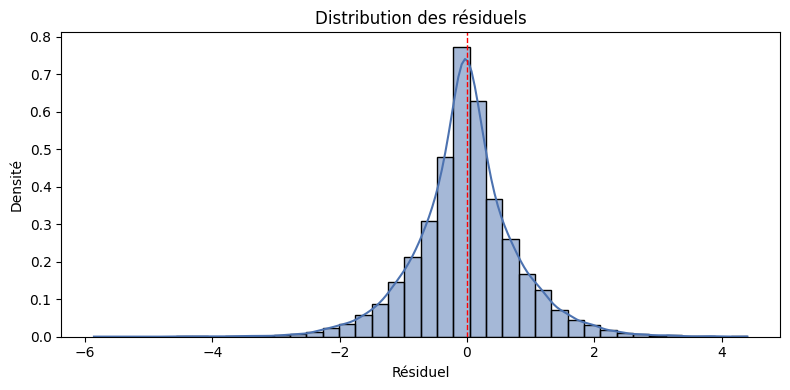

In [12]:
# On souhaite maintenant expliquer le résiduel du modèle de facteurs (FF5 + Momentum) en ajoutant des variables macroéconomiques.
# On veut comprendre dans quel contexte le fonds fait nettement mieux ou nettement pire que ce qu’on attendrait, compte tenu de son exposition aux facteurs et du régime macro.
# Le résiduel du modèle de facteurs est netté des expositions structurelles (Value, Size, Momentum…)
# Il mesure la sur-/sous-performance conditionnelle au style et se prête bien à la recherche de règles

# On commence par sélectionner les variables pertinentes de df_rolling avant d'ajouter des variables macroéconomiques.
df_train = df_rolling[['ticker', 'window_end', 'residual', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']].copy()

# TODO: représente la distribution des résiduels

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(df_train['residual'], bins=40, kde=True, stat='density', color='#4C72B0')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title('Distribution des résiduels')
plt.xlabel('Résiduel')
plt.ylabel('Densité')
plt.tight_layout()
plt.show()


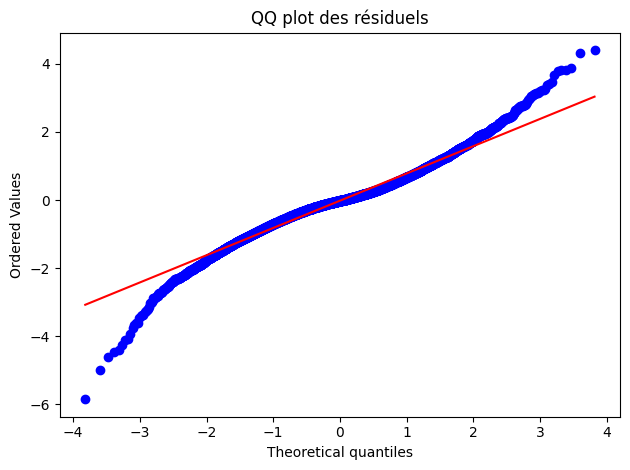

In [13]:
import scipy.stats as stats

stats.probplot(df_train['residual'], dist="norm", plot=plt)
plt.title('QQ plot des résiduels')
plt.tight_layout()
plt.show()


In [14]:
# À partir du résiduel du modèle de facteurs, on calcule une variable cible ordinale à 3 états
# Underperformance : sous-performance anormale < 1 sigma,
# Neutral : performance en ligne,
# Overperformance : surperformance anormale > 1 sigma.

sigma = df_train['residual'].std()

df_train = df_train.assign(
    target=pd.cut(
        df_train['residual'],
        bins=[-float('inf'), -sigma, sigma, float('inf')],
        labels=['Underperformance', 'Neutral', 'Overperformance'],
        ordered=True
    )
)
df_train

,ticker,window_end,residual,Mkt-RF,SMB,HML,RMW,CMA,UMD,target
0,IVV,2003-04-30,0.229758,0.965836,-0.115679,0.010207,0.075087,0.038232,-0.057851,Neutral
1,IVV,2003-05-31,-0.181694,0.970877,-0.111714,0.004733,0.082175,0.039776,-0.054737,Neutral
2,IVV,2003-06-30,0.056533,0.965572,-0.126066,0.014852,0.089601,0.037990,-0.067499,Neutral
3,IVV,2003-07-31,0.419603,0.965890,-0.125582,0.019868,0.086228,0.036473,-0.067174,Neutral
4,IVV,2003-08-31,0.067041,0.974591,-0.128383,0.016890,0.083826,0.040682,-0.060855,Neutral
...,...,...,...,...,...,...,...,...,...,...
10351,DIVB,2025-06-30,0.422693,0.910997,-0.040321,0.485199,0.089559,0.057023,-0.082608,Neutral
10352,DIVB,2025-07-31,-1.677307,0.906928,-0.042379,0.482057,0.085280,0.079203,-0.082411,Underperformance
10353,DIVB,2025-08-31,-0.150376,0.913511,-0.047904,0.488686,0.103601,0.062368,-0.081578,Neutral
10354,DIVB,2025-09-30,-1.017698,0.900691,-0.034407,0.476346,0.114407,0.079742,-0.089343,Underperformance


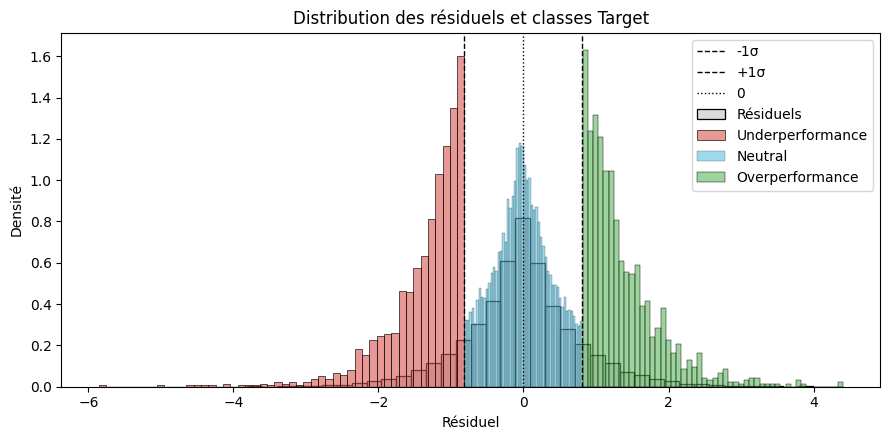

In [15]:
# Visualisation de la distribution des résiduels par classe Target
sigma = df_train['residual'].std()

# Palette par classe
palette = {
    'Underperformance': '#d9534f',  # rouge
    'Neutral': '#5bc0de',           # bleu clair
    'Overperformance': '#5cb85c'    # vert
}

plt.figure(figsize=(9, 4.5))

# Histogramme global
sns.histplot(df_train['residual'], bins=50, stat='density', color='#999999', alpha=0.35, label='Résiduels')

# Histogrammes par classe
for cls, color in palette.items():
    subset = df_train[df_train['target'] == cls]
    if len(subset):
        sns.histplot(subset['residual'], bins=50, stat='density', color=color, alpha=0.6, label=cls)

# Lignes de seuil ±1σ
plt.axvline(-sigma, color='black', linestyle='--', linewidth=1, label='-1σ')
plt.axvline(sigma, color='black', linestyle='--', linewidth=1, label='+1σ')
plt.axvline(0, color='black', linestyle=':', linewidth=1, label='0')

plt.title('Distribution des résiduels et classes Target')
plt.xlabel('Résiduel')
plt.ylabel('Densité')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Alternative : On change l'horizon temporel de la cible
# Comme les macros macroéconomiques FRED sont relativement lentes, on reconstruit une cible sur un horizon 3, 6 ou 12 mois :
# Exemple : y_3m = somme des résiduels sur les 3 derniers mois
# Cela réduit le bruit mensuel et met en cohérence la granularité avec les régimes macro.

df_train = df_train.sort_values(['ticker', 'window_end'])

horizon = 3  # 3, 6 ou 12

# Somme roulante des résiduels par ticker
df_train[f'residual_{horizon}m'] = (
    df_train
    .groupby('ticker')['residual']
    .transform(lambda s: s.rolling(window=horizon, min_periods=horizon).sum())
)

# Seuils (ici au global ; si tu préfères par ticker, calcule sigma dans une transform)
sigma = df_train[f'residual_{horizon}m'].std()

df_train = df_train.assign(
    target_3m=pd.cut(
        df_train[f'residual_{horizon}m'],
        bins=[-float('inf'), -sigma, sigma, float('inf')],
        labels=['Underperformance', 'Neutral', 'Overperformance'],
        ordered=True
    )
)

# Option : filtrer les lignes sans fenêtre complète
df_train = df_train.dropna(subset=[f'residual_{horizon}m', 'target_3m'])
# df_train.to_csv("df_train.csv", index=False)
df_train


,ticker,window_end,residual,Mkt-RF,SMB,HML,RMW,CMA,UMD,target,residual_3m,target_3m
9877,DGRO,2017-08-31,0.320358,0.969084,-0.127385,0.037286,0.094913,0.272130,0.058930,Neutral,0.071809,Neutral
9878,DGRO,2017-09-30,0.208237,0.973467,-0.120312,0.039493,0.092195,0.277382,0.062515,Neutral,-0.533721,Neutral
9879,DGRO,2017-10-31,-0.078235,0.970703,-0.138696,0.057358,0.089897,0.263235,0.061913,Neutral,0.450361,Neutral
9880,DGRO,2017-11-30,0.623797,0.978266,-0.133915,0.060372,0.122811,0.259756,0.062801,Neutral,0.753799,Neutral
9881,DGRO,2017-12-31,-0.679486,0.975461,-0.129660,0.068998,0.133818,0.220223,0.060264,Neutral,-0.133924,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
9643,VLUE,2025-06-30,1.627178,1.023979,-0.080027,0.508061,-0.060760,0.142669,-0.179014,Overperformance,1.386067,Neutral
9644,VLUE,2025-07-31,-1.489432,1.034124,-0.073330,0.510460,-0.041835,0.117027,-0.175715,Underperformance,-0.020013,Neutral
9645,VLUE,2025-08-31,1.236402,1.037251,-0.061478,0.518426,-0.021793,0.114205,-0.181894,Overperformance,1.374148,Neutral
9646,VLUE,2025-09-30,2.770322,1.052390,-0.088855,0.547499,-0.064979,0.070883,-0.155254,Overperformance,2.517292,Overperformance


In [ ]:
# Calcul du % de chaque classe target_3m dans le dataset
percentages = df_train['target_3m'].value_counts(normalize=True) * 100
percentages

target_3m
Neutral             74.288222
Underperformance    13.572543
Overperformance     12.139236
Name: proportion, dtype: float64

### Utilisation de séries macroéconomiques FRED

On cherche des règles explicatives du type :   
“Lorsque {courbe des taux inversée} & {VIX en régime High} & {fond = Growth large caps}, la probabilité d’alpha anormalement négatif sur 3 mois double.”

Pour cela, nous avons téléchargé les séries suivantes depuis la base FRED qu'il faut préparer pour servir de variables explicatives :

- `FEDFUNDS` – Effective Federal Funds Rate  
- `DGS10` – 10-Year Treasury Constant Maturity Rate  
- `T10Y3M` – 10Y − 3M Treasury Yield Spread  
- `CPIAUCNS` – CPI All Items, U.S. City Average (NSA)  
- `CPILFESL` – Core CPI (All Items Less Food and Energy)  
- `INDPRO` – Industrial Production Index  
- `UNRATE` – Civilian Unemployment Rate  
- `HOUST` – Housing Starts  
- `BAMLH0A0HYM2` – ICE BofA US High Yield OAS  
- `NFCI` – Chicago Fed National Financial Conditions Index  
- `VIXCLS` – CBOE Volatility Index (VIX)  
- `DTWEXBGS` – Nominal Broad U.S. Dollar Index  
- `MCOILWTICO` – Crude Oil Prices: WTI (monthly)

In [17]:
df_fred = pd.read_csv("fred_macro_series.csv", parse_dates=["date"])
# Dates en index, tri
df_fred = df_fred.assign(date=pd.to_datetime(df_fred['date'])).set_index('date').sort_index()

df_fred

,FEDFUNDS,DGS10,T10Y3M,CPIAUCNS,CPILFESL,INDPRO,UNRATE,HOUST,BAMLH0A0HYM2,NFCI,VIXCLS,DTWEXBGS,MCOILWTICO
date,,,,,,,,,,,,,
1990-01-01,8.23,NaN,NaN,127.4,132.1,61.729,5.4,1551.0,NaN,NaN,NaN,NaN,22.86
1990-01-02,NaN,7.94,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.24,NaN,NaN
1990-01-03,NaN,7.99,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.19,NaN,NaN
1990-01-04,NaN,7.98,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.22,NaN,NaN
1990-01-05,NaN,7.99,0.20,NaN,NaN,NaN,NaN,NaN,NaN,0.03172,20.11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,NaN,4.04,0.13,NaN,NaN,NaN,NaN,NaN,3.15,NaN,20.52,NaN,NaN
2025-11-25,NaN,4.01,0.11,NaN,NaN,NaN,NaN,NaN,3.10,NaN,18.56,NaN,NaN
2025-11-26,NaN,4.00,0.08,NaN,NaN,NaN,NaN,NaN,3.00,NaN,17.19,NaN,NaN


## Explication du choix des variables macro-économiques pour expliquer les régimes

### Taux courts & policy stance (1 variable)
#### FEDFUNDS – Effective Federal Funds Rate 
Description : Taux directeur de la Fed (overnight) – niveau de la politique monétaire.  
Utilité :
- Capture le régime monétaire (accommodant / restrictif).
- Permet des règles du type : “Alpha des stratégies Growth dégrade lorsque FEDFUNDS > X”.

### Taux longs & courbe des taux (2 variables)
#### DGS10 – 10-Year Treasury Constant Maturity Rate 
Description : Rendement des Treasuries 10 ans, base quotidienne (à agréger en mensuel).  
Utilité :
- Proxy pour le coût du capital de long terme, prime de duration, valeur de l’actualisation.
- Impact direct sur les styles Growth vs Value.

#### T10Y3M – 10Y − 3M Treasury Yield Spread 
Description : Différence entre le 10Y constant maturity et le 3M constant maturity.  
Utilité :
- Indicateur de slope de courbe / risque de récession (inversion vs pente normale).
- Utile pour des règles : “Les portefeuilles High Beta sous-performent quand la courbe est inversée (T10Y3M < 0).”

### Inflation (2 variables)
#### CPIAUCNS – CPI All Items, U.S. City Average (NSA) 
Description : Indice des prix à la consommation global (niveau).  
Utilité :
- Permet de construire des taux d’inflation YoY ou MoM.
- Influence style Value, secteurs defensifs, pricing power.

#### CPILFESL – Core CPI (All Items Less Food and Energy) 
Description : CPI hors énergie et alimentaire.  
Utilité :
- Mesure l’inflation sous-jacente utilisée par les banques centrales.
- Règles du type : “Quality surperforme lorsque l’inflation core > X” (prime à la résilience des marges).

### Croissance réelle & cycle économique (3 variables)
#### INDPRO – Industrial Production Index 
Description : Production industrielle réelle agrégée US.  
Utilité :
- Bon indicateur mensuel de cycle (accélération / décélération).
- Liens naturels avec Value/Cyclical vs Growth/Defensive.

#### UNRATE – Civilian Unemployment Rate
Description : Taux de chômage officiel (U-3).  
Utilité :
- Variable de cycle et de slack économique.
- Règles : “Les stratégies High Yield / Value souffrent quand le chômage remonte au-dessus de X %”.

#### HOUST – Housing Starts 
Description : Nombre de nouveaux logements privés commencés (housing starts).  
Utilité :
- Proxy avancé de cycle immobilier et confiance des ménages.
- Intéressant pour secteurs cyclicals, sensibilité aux taux, banques.

### Conditions financières & appétit pour le risque (3 variables)
#### BAMLH0A0HYM2 – ICE BofA US High Yield OAS 
Description : Spread option-adjusted des obligations High Yield US.  
Utilité :
- Mesure le stress crédit / risk-off.
- Règles typiques : “Les facteurs Value + High Dividend sous-performent quand le spread HY > X %”.

#### NFCI – Chicago Fed National Financial Conditions Index 
Description : Indice synthétique hebdo des conditions financières (money markets, crédit, equities, shadow banking).  
Utilité :
- Résume l’état tight/loose du système financier.
- Très puissant pour expliquer des régimes de performance facteur (Value, Momentum, Low Vol).

#### VIXCLS – CBOE Volatility Index (VIX) 
Description : Volatilité implicite 30 jours sur le S&P 500.  
Utilité :
- Proxy d’incertitude / “fear gauge”.
- Règles : “Les stratégies Low Vol et Quality génèrent du sur-alpha quand VIX > 20”, ou “Momentum casse quand les chocs de VIX > X”.

### Devises & matières premières (2 variables)
#### DTWEXBGS – Nominal Broad U.S. Dollar Index 
Description : Indice du dollar US contre un panier large de devises (pondéré par le commerce).  
Utilité :
- Impacte les earnings des exportateurs, les matières premières, les secteurs mondialisés.
- Utile pour expliquer les régimes sectoriels et style (ex : EM vs US, cyclicals vs defensives).

#### MCOILWTICO – Crude Oil Prices: WTI (monthly) 
Description : Prix mensuel du WTI à Cushing, Oklahoma.  
Utilité :
- Variable clé pour énergie, transports, inflation, value/cycle.
- Permet des règles : “Les stratégies Value énergétiques surperforment lorsque le WTI > X $/baril.”

In [18]:
# FEDFUNDS – Effective Federal Funds Rate
# FEDFUNDS_level : niveau de la politique monétaire.
# FEDFUNDS_delta : variation mensuelle du taux directeur - capture les chocs de politique monétaire (hikes/cuts).

# 1) Niveau mensuel
fedfunds_level = df_fred['FEDFUNDS'].resample('MS').first()          # valeur au 1er du mois (ou premier point du mois)
fedfunds_level.index = fedfunds_level.index.to_period('M').to_timestamp('M')  # index fin de mois

# 2) Delta mensuel : différence entre le 1er du mois et le 1er du mois suivant
fedfunds_delta = fedfunds_level - fedfunds_level.shift(1)          # valeur au 1er du mois - valeur au 1er du mois précédent
fedfunds_delta.index = fedfunds_delta.index.to_period('M').to_timestamp('M')  # index fin de mois

df_fedfunds_monthly = pd.DataFrame({
    'FEDFUNDS_level': fedfunds_level,
    'FEDFUNDS_delta': fedfunds_delta
})

df_fedfunds_monthly

,FEDFUNDS_level,FEDFUNDS_delta
date,,
1990-01-31,8.23,NaN
1990-02-28,8.24,0.01
1990-03-31,8.28,0.04
1990-04-30,8.26,-0.02
1990-05-31,8.18,-0.08
...,...,...
2025-07-31,4.33,0.00
2025-08-31,4.33,0.00
2025-09-30,4.22,-0.11


In [19]:
# DGS10 – 10Y Treasury
# DGS10_level : coût du capital long terme, duration, pression sur Growth
# DGS10_delta_1m : choc de taux long (repricing rapide de la duration).
# DGS10_delta_3m : choc de taux long sur 3 mois (repricing plus lent de la duration).

# Moyenne mensuelle (fenêtre [1er du mois, 1er du mois suivant), indexée fin de mois)
dgs10_level = (
    df_fred['DGS10']
    .resample('ME', closed='left', label='right')  # 'ME' = month-end label
    .mean()
)

# Valeurs au 1er de chaque mois (ou première obs du mois)
start_vals = df_fred['DGS10'].resample('MS').first()

# Choc 1 mois : valeur(1er mois+1) - valeur(1er mois)
dgs10_delta_1m = start_vals.shift(-1) - start_vals
dgs10_delta_1m.index = dgs10_delta_1m.index.to_period('M').to_timestamp('M')

# Choc 3 mois : valeur(1er mois+1) - valeur(1er mois-2)
dgs10_delta_3m = start_vals.shift(-1) - start_vals.shift(2)
dgs10_delta_3m.index = dgs10_delta_3m.index.to_period('M').to_timestamp('M')

# Assemble
df_dgs10_monthly = pd.DataFrame({
    'DGS10_level': dgs10_level,
    'DGS10_delta_1m': dgs10_delta_1m,
    'DGS10_delta_3m': dgs10_delta_3m
})
df_dgs10_monthly


,DGS10_level,DGS10_delta_1m,DGS10_delta_3m
date,,,
1990-01-31,8.195500,0.48,NaN
1990-02-28,8.468947,0.17,NaN
1990-03-31,8.585217,0.06,0.71
1990-04-30,8.772105,0.43,0.66
1990-05-31,8.778182,-0.64,-0.15
...,...,...,...
2025-07-31,4.385909,-0.03,-0.02
2025-08-31,4.269545,0.05,-0.18
2025-09-30,4.118500,-0.16,-0.14


In [20]:
# T10Y3M – 10Y − 3M Spread
# T10Y3M_level : niveau de la courbe des taux (inversion / steepening) - régime de cycle / probabilité de récession

t10y3m_level = (
    df_fred['T10Y3M']
    .resample('ME')  # fin de mois
    .apply(lambda s: s.dropna().iloc[-1] if len(s.dropna()) else np.nan)
)

t10y3m_level.name = 'T10Y3M_level'

df_t10y3m_monthly = pd.DataFrame({
    'T10Y3M_level': t10y3m_level
})
df_t10y3m_monthly

,T10Y3M_level
date,
1990-01-31,0.43
1990-02-28,0.47
1990-03-31,0.58
1990-04-30,0.97
1990-05-31,0.59
...,...
2025-07-31,-0.04
2025-08-31,0.00
2025-09-30,0.14


In [21]:
# Inflation (indices de prix)

# Inflation yoy que regarde le marché :
# CPI_headline_yoy = 100 * (CPIAUCNS_t / CPIAUCNS_{t-12} - 1)
# CPI_core_yoy = 100 * (CPILFESL_t / CPILFESL_{t-12} - 1)

# Accélération/décélération de l’inflation :
# ΔCPI_core_yoy = CPI_core_yoy - CPI_core_yoy_{t-3}

cpi_headline_m = df_fred['CPIAUCNS'].resample('ME').first()          # valeur au 1er du mois (ou premier point du mois)
cpi_core_m = df_fred['CPILFESL'].resample('ME').first()          # valeur au 1er du mois (ou premier point du mois)

# YoY : 100 * (t / t-12 - 1)
cpi_headline_yoy = (cpi_headline_m / cpi_headline_m.shift(12) - 1) * 100
cpi_core_yoy = (cpi_core_m / cpi_core_m.shift(12) - 1) * 100

# ΔYoY core : différence vs t-3 mois
cpi_core_yoy_delta_3m = cpi_core_yoy - cpi_core_yoy.shift(3)

df_cpi_monthly = pd.DataFrame({
    'CPI_headline_yoy': cpi_headline_yoy,
    'CPI_core_yoy': cpi_core_yoy,
    'cpi_core_yoy_delta_3m': cpi_core_yoy_delta_3m
})

df_cpi_monthly

,CPI_headline_yoy,CPI_core_yoy,cpi_core_yoy_delta_3m
date,,,
1990-01-31,NaN,NaN,NaN
1990-02-28,NaN,NaN,NaN
1990-03-31,NaN,NaN,NaN
1990-04-30,NaN,NaN,NaN
1990-05-31,NaN,NaN,NaN
...,...,...,...
2025-07-31,2.704902,3.048603,0.267082
2025-08-31,2.916174,3.112191,0.345042
2025-09-30,3.012677,3.025543,0.117673


In [22]:
# INDPRO – Industrial Production
# Mesure du cycle industriel
# Croissance YoY : INDPRO_yoy = 100 * (INDPRO_t / INDPRO_{t-12} - 1)

# Changement de croissance YoY sur 3 mois
# indpro_yoy_delta_3m = INDPRO_yoy_t - INDPRO_yoy_{t-3}
# Rôle : détecter accélérations/décélérations.

indpro_m = df_fred['INDPRO'].resample('ME').first()          # valeur au 1er du mois (ou premier point du mois)
# YoY : 100 * (t / t-12 - 1)
indpro_yoy = (indpro_m / indpro_m.shift(12) - 1) * 100
indpro_yoy_delta_3m = indpro_yoy - indpro_yoy.shift(3)

df_indpro_monthly = pd.DataFrame({
    'INDPRO_yoy': indpro_yoy,
    'indpro_yoy_delta_3m': indpro_yoy_delta_3m
})

df_indpro_monthly

,INDPRO_yoy,indpro_yoy_delta_3m
date,,
1990-01-31,NaN,NaN
1990-02-28,NaN,NaN
1990-03-31,NaN,NaN
1990-04-30,NaN,NaN
1990-05-31,NaN,NaN
...,...,...
2025-07-31,1.371833,0.376855
2025-08-31,0.835898,0.565531
2025-09-30,NaN,NaN


In [23]:
# UNRATE – Unemployment Rate
# UNRATE_level (en %) : niveau du taux de chômage - cycle de l’emploi
# UNRATE_delta_3m = UNRATE_t - UNRATE_{t-3}

unrate_level = df_fred['UNRATE'].resample('ME').first()          # valeur au 1er du mois (ou premier point du mois)
unrate_delta_3m = unrate_level - unrate_level.shift(3)
df_unrate_monthly = pd.DataFrame({
    'UNRATE_level': unrate_level,
    'UNRATE_delta_3m': unrate_delta_3m
})
df_unrate_monthly

,UNRATE_level,UNRATE_delta_3m
date,,
1990-01-31,5.4,NaN
1990-02-28,5.3,NaN
1990-03-31,5.2,NaN
1990-04-30,5.4,0.0
1990-05-31,5.4,0.1
...,...,...
2025-07-31,4.2,0.0
2025-08-31,4.3,0.1
2025-09-30,4.4,0.3


In [24]:
# HOUST – Housing Starts
# croissance YoY : HOUST_yoy = 100 * (HOUST_t / HOUST_{t-12} - 1)
# Rôle : indicateur avancé du cycle économique.

houst_m = df_fred['HOUST'].resample('ME').first()          # valeur au 1er du mois (ou premier point du mois)
houst_yoy = (houst_m / houst_m.shift(12) -  1) * 100
df_houst_monthly = pd.DataFrame({
    'HOUST_yoy': houst_yoy
})
df_houst_monthly

,HOUST_yoy
date,
1990-01-31,NaN
1990-02-28,NaN
1990-03-31,NaN
1990-04-30,NaN
1990-05-31,NaN
...,...
2025-07-31,12.964427
2025-08-31,-6.038821
2025-09-30,NaN


In [25]:
# BAMLH0A0HYM2 – HY OAS Spread
# Niveau du spread HY OAS (en bps) : BAMLH0A0HYM2_level
# Moyenne du mois
# Rôle : indicateur du risque de crédit et de l’appétit pour le risque
hy_oas_spread_level = (
    df_fred['BAMLH0A0HYM2']
    .resample('ME')  # fin de mois
    .mean()
)
hy_oas_spread_level.name = 'hy_oas_spread_level'

# Capture les chocs de spread (aversion au risque brutale).
# HY_OAS_delta_1m et HY_OAS_delta_3m

# Valeurs au 1er de chaque mois (ou première obs du mois)
start_vals = df_fred['BAMLH0A0HYM2'].resample('MS').first()

# Choc 1 mois : valeur(1er mois+1) - valeur(1er mois)
hy_oas_delta_1m = start_vals.shift(-1) - start_vals
hy_oas_delta_1m.index = hy_oas_delta_1m.index.to_period('M').to_timestamp('M')

# Choc 3 mois : valeur(1er mois+1) - valeur(1er mois-2)
hy_oas_delta_3m = start_vals.shift(-1) - start_vals.shift(2)
hy_oas_delta_3m.index = hy_oas_delta_3m.index.to_period('M').to_timestamp('M')

df_hy_spread_monthly = pd.DataFrame({
    'hy_oas_spread_level': hy_oas_spread_level,
    'hy_oas_delta_1m': hy_oas_delta_1m,
    'hy_oas_delta_3m': hy_oas_delta_3m,
})
df_hy_spread_monthly

,hy_oas_spread_level,hy_oas_delta_1m,hy_oas_delta_3m
date,,,
1990-01-31,NaN,NaN,NaN
1990-02-28,NaN,NaN,NaN
1990-03-31,NaN,NaN,NaN
1990-04-30,NaN,NaN,NaN
1990-05-31,NaN,NaN,NaN
...,...,...,...
2025-07-31,2.889130,0.22,-0.65
2025-08-31,2.902727,-0.29,-0.43
2025-09-30,2.788182,-0.03,-0.10


In [26]:
# NFCI – Chicago Fed NFCI
# NFCI_level : niveau du stress financier global
# 0 : conditions plus tight que la moyenne historique.
# < 0 : conditions loose.

nfci_level = (
    df_fred['NFCI']
    .resample('ME')  # fin de mois
    .mean()
)

# NFCI_delta_4w pour capturer un durcissement soudain.
nfci_last = (
    df_fred['NFCI']
    .resample('ME')  # fin de mois
    .last()
)

NFCI_delta_4w = nfci_last - nfci_last.shift(1)
df_nfci_monthly = pd.DataFrame({
    'NFCI_level': nfci_level,
    'NFCI_delta_4w': NFCI_delta_4w
})
df_nfci_monthly

,NFCI_level,NFCI_delta_4w
date,,
1990-01-31,0.047185,NaN
1990-02-28,0.055600,-0.01337
1990-03-31,0.052402,0.02599
1990-04-30,0.102110,0.03369
1990-05-31,0.045093,-0.11648
...,...,...
2025-07-31,-0.513880,-0.02309
2025-08-31,-0.528576,-0.00979
2025-09-30,-0.529888,0.00284


In [ ]:
# VIXCLS – VIX
# VIX_level : niveau du VIX (en %) - indicateur d’aversion au risque
# Moyenne mensuelle
vix_level = (
    df_fred['VIXCLS']
    .resample('ME')  # fin de mois
    .mean()
)

# vix_delta_1m pour capturer les chocs d’aversion aux risques brutaux.
vix_delta_1m = vix_level - vix_level.shift(1)

# Amplitude mensuelle du VIX
vix_max = (
    df_fred['VIXCLS']
    .resample('ME')  # fin de mois
    .max()
)
vix_min = (
    df_fred['VIXCLS']
    .resample('ME')  # fin de mois
    .min()
)
vix_amplitude_m = vix_max - vix_min

df_vix_monthly = pd.DataFrame({
    'VIX_level': vix_level,
    'VIX_delta_1m': vix_delta_1m,
    'VIX_amplitude_m': vix_amplitude_m
})
df_vix_monthly

,VIX_level,VIX_delta_1m,VIX_amplitude_m
date,,,
1990-01-31,23.347273,NaN,10.01
1990-02-28,23.262632,-0.084641,5.16
1990-03-31,20.062273,-3.200359,5.12
1990-04-30,21.403500,1.341227,6.43
1990-05-31,18.097727,-3.305773,3.42
...,...,...,...
2025-07-31,16.381304,-2.022029,2.86
2025-08-31,15.750000,-0.631304,6.16
2025-09-30,15.789091,0.039091,2.46


In [28]:
# DTWEXBGS – Dollar Index
# USD_index_level : niveau du Dollar Index - impact sur les multinationales, inflation importée
USD_index_level = (
    df_fred['DTWEXBGS']
    .resample('ME')  # fin de mois
    .mean()
)

# USD_3m_return = 100 * (USD_index_level_t / USD_index_level_{t-3} - 1)
USD_3m_return = (USD_index_level / USD_index_level.shift(3) - 1) * 100

# USD_12m_return = 100 * (USD_index_level_t / USD_index_level_{t-12} - 1)
USD_12m_return = (USD_index_level / USD_index_level.shift(12) - 1) * 100

df_usd_monthly = pd.DataFrame({
    'USD_index_level': USD_index_level,
    'USD_3m_return': USD_3m_return,
    'USD_12m_return': USD_12m_return
})
df_usd_monthly

,USD_index_level,USD_3m_return,USD_12m_return
date,,,
1990-01-31,NaN,NaN,NaN
1990-02-28,NaN,NaN,NaN
1990-03-31,NaN,NaN,NaN
1990-04-30,NaN,NaN,NaN
1990-05-31,NaN,NaN,NaN
...,...,...,...
2025-07-31,120.526564,-3.157038,-2.581807
2025-08-31,120.984448,-1.387648,-1.542783
2025-09-30,120.453400,-0.430929,-1.372452


In [29]:
# MCOILWTICO – WTI Oil Price
# WTI_price_level : niveau du prix du WTI - impact sur les secteurs sensibles à l’énergie
WTI_price_level = (
    df_fred['MCOILWTICO']
    .resample('ME')  # fin de mois
    .mean()
)

# WTI_1m_return = 100 * (WTI_price_level_t / WTI_price_level_{t-1} - 1)
WTI_1m_return = (WTI_price_level / WTI_price_level.shift(1) - 1) * 100

# WTI_3m_return = 100 * (WTI_price_level_t / WTI_price_level_{t-3} - 1)
WTI_3m_return = (WTI_price_level / WTI_price_level.shift(3) - 1) * 100

# WTI_12m_return = 100 * (WTI_price_level_t / WTI_price_level_{t-12} - 1)
WTI_12m_return = (WTI_price_level / WTI_price_level.shift(12) - 1) * 100

df_wti_monthly = pd.DataFrame({
    'WTI_price_level': WTI_price_level,
    'WTI_1m_return': WTI_1m_return,
    'WTI_3m_return': WTI_3m_return,
    'WTI_12m_return': WTI_12m_return
})
df_wti_monthly

,WTI_price_level,WTI_1m_return,WTI_3m_return,WTI_12m_return
date,,,,
1990-01-31,22.86,NaN,NaN,NaN
1990-02-28,22.11,-3.280840,NaN,NaN
1990-03-31,20.39,-7.779285,NaN,NaN
1990-04-30,18.43,-9.612555,-19.378828,NaN
1990-05-31,18.20,-1.247965,-17.684306,NaN
...,...,...,...,...
2025-07-31,68.39,0.322723,7.632987,-16.393643
2025-08-31,64.86,-5.161573,4.326846,-15.414710
2025-09-30,63.96,-1.387604,-6.175737,-8.940774


In [30]:
# Assemble tous les dataframes macroéconomiques en un seul DataFrame mensuel (en conservant les mois avec NaN)
macro_frames = [
    df_fedfunds_monthly, df_dgs10_monthly, df_t10y3m_monthly,
    df_cpi_monthly, df_indpro_monthly, df_unrate_monthly,
    df_houst_monthly, df_hy_spread_monthly, df_nfci_monthly,
    df_vix_monthly, df_usd_monthly, df_wti_monthly
]

# Convertir les Series en DataFrame si besoin (sécurité)
macro_frames = [f.to_frame() if isinstance(f, pd.Series) else f.copy() for f in macro_frames]

# Concaténation en conservant l'union des index (mois) -> NaN où données manquent
df_macro_monthly = pd.concat(macro_frames, axis=1, join="outer").sort_index()

# Optionnel : vérifier les colonnes et les valeurs manquantes
print("Macro monthly shape:", df_macro_monthly.shape)
print(df_macro_monthly.columns.tolist())
print("Missing values per column:\n", df_macro_monthly.isna().sum())

# Sauvegarde (optionnelle)
df_macro_monthly.to_csv("fred_macro_monthly.csv", index=True)

# Affichage bref
df_macro_monthly.head()

Macro monthly shape: (431, 29)
['FEDFUNDS_level', 'FEDFUNDS_delta', 'DGS10_level', 'DGS10_delta_1m', 'DGS10_delta_3m', 'T10Y3M_level', 'CPI_headline_yoy', 'CPI_core_yoy', 'cpi_core_yoy_delta_3m', 'INDPRO_yoy', 'indpro_yoy_delta_3m', 'UNRATE_level', 'UNRATE_delta_3m', 'HOUST_yoy', 'hy_oas_spread_level', 'hy_oas_delta_1m', 'hy_oas_delta_3m', 'NFCI_level', 'NFCI_delta_4w', 'VIX_level', 'VIX_delta_1m', 'VIX_amplitude_m', 'USD_index_level', 'USD_3m_return', 'USD_12m_return', 'WTI_price_level', 'WTI_1m_return', 'WTI_3m_return', 'WTI_12m_return']
Missing values per column:
 FEDFUNDS_level             1
FEDFUNDS_delta             2
DGS10_level                0
DGS10_delta_1m             1
DGS10_delta_3m             3
T10Y3M_level               0
CPI_headline_yoy          14
CPI_core_yoy              14
cpi_core_yoy_delta_3m     17
INDPRO_yoy                15
indpro_yoy_delta_3m       18
UNRATE_level               2
UNRATE_delta_3m            5
HOUST_yoy                 15
hy_oas_spread_level 

,FEDFUNDS_level,FEDFUNDS_delta,DGS10_level,DGS10_delta_1m,DGS10_delta_3m,T10Y3M_level,CPI_headline_yoy,CPI_core_yoy,cpi_core_yoy_delta_3m,INDPRO_yoy,...,VIX_level,VIX_delta_1m,VIX_amplitude_m,USD_index_level,USD_3m_return,USD_12m_return,WTI_price_level,WTI_1m_return,WTI_3m_return,WTI_12m_return
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,8.23,NaN,8.195500,0.48,NaN,0.43,NaN,NaN,NaN,NaN,...,23.347273,NaN,10.01,NaN,NaN,NaN,22.86,NaN,NaN,NaN
1990-02-28,8.24,0.01,8.468947,0.17,NaN,0.47,NaN,NaN,NaN,NaN,...,23.262632,-0.084641,5.16,NaN,NaN,NaN,22.11,-3.280840,NaN,NaN
1990-03-31,8.28,0.04,8.585217,0.06,0.71,0.58,NaN,NaN,NaN,NaN,...,20.062273,-3.200359,5.12,NaN,NaN,NaN,20.39,-7.779285,NaN,NaN
1990-04-30,8.26,-0.02,8.772105,0.43,0.66,0.97,NaN,NaN,NaN,NaN,...,21.403500,1.341227,6.43,NaN,NaN,NaN,18.43,-9.612555,-19.378828,NaN
1990-05-31,8.18,-0.08,8.778182,-0.64,-0.15,0.59,NaN,NaN,NaN,NaN,...,18.097727,-3.305773,3.42,NaN,NaN,NaN,18.20,-1.247965,-17.684306,NaN


In [31]:
# Jointure entre df_train et df_macro_monthly sur la date de fin de fenêtre
df_train = df_train.assign(date=pd.to_datetime(df_train['window_end'])).set_index('date')
df_train = df_train.merge(df_macro_monthly, left_on='date', right_on='date', how='left')
df_train.to_csv("df_train.csv", index=False)
df_train

,ticker,window_end,residual,Mkt-RF,SMB,HML,RMW,CMA,UMD,target,...,VIX_level,VIX_delta_1m,VIX_amplitude_m,USD_index_level,USD_3m_return,USD_12m_return,WTI_price_level,WTI_1m_return,WTI_3m_return,WTI_12m_return
date,,,,,,,,,,,,,,,,,,,,,
2017-08-31,DGRO,2017-08-31,0.320358,0.969084,-0.127385,0.037286,0.094913,0.272130,0.058930,Neutral,...,11.975652,1.711152,6.11,109.905861,-3.809998,-1.375207,48.04,3.023804,-0.907591,7.423971
2017-09-30,DGRO,2017-09-30,0.208237,0.973467,-0.120312,0.039493,0.092195,0.277382,0.062515,Neutral,...,10.438000,-1.537652,2.72,108.854245,-3.464011,-3.082900,49.82,3.705246,10.270031,10.270031
2017-10-31,DGRO,2017-10-31,-0.078235,0.970703,-0.138696,0.057358,0.089897,0.263235,0.061913,Neutral,...,10.125455,-0.312545,2.11,110.889176,-0.154311,-2.278498,51.58,3.532718,10.615484,3.615910
2017-11-30,DGRO,2017-11-30,0.623797,0.978266,-0.133915,0.060372,0.122811,0.259756,0.062801,Neutral,...,10.540476,0.415022,3.99,111.163525,1.144310,-4.258114,56.64,9.810004,17.901749,24.047306
2017-12-31,DGRO,2017-12-31,-0.679486,0.975461,-0.129660,0.068998,0.133818,0.220223,0.060264,Neutral,...,10.264500,-0.275976,2.34,110.875810,1.857130,-5.961604,57.88,2.189266,16.178242,11.371945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,VLUE,2025-06-30,1.627178,1.023979,-0.080027,0.508061,-0.060760,0.142669,-0.179014,Overperformance,...,18.403333,-2.058939,5.85,120.974715,-4.357557,-2.464026,68.17,9.650957,-0.102579,-14.541808
2025-07-31,VLUE,2025-07-31,-1.489432,1.034124,-0.073330,0.510460,-0.041835,0.117027,-0.175715,Underperformance,...,16.381304,-2.022029,2.86,120.526564,-3.157038,-2.581807,68.39,0.322723,7.632987,-16.393643
2025-08-31,VLUE,2025-08-31,1.236402,1.037251,-0.061478,0.518426,-0.021793,0.114205,-0.181894,Overperformance,...,15.750000,-0.631304,6.16,120.984448,-1.387648,-1.542783,64.86,-5.161573,4.326846,-15.414710
